In [1]:
import seaborn as sns
sns.set()
sns.set(font_scale=1.6) 
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
from scipy import linalg
from scipy.sparse import diags

# Detecting a resonance far from the absorbtion peak

We will use the Lorentz-Drude model

In [3]:
def format_xticks(x, pos=None):
    """
    The exponential notation for numbers using LaTeX
    """

    if np.isclose(x, 0):
        return "0"

    if x < 0:
        return str(x)

    log10x = np.log10(x)
    exponent = int(np.floor(log10x))
    prefactor = 10. ** (log10x - exponent)

    if np.isclose(prefactor, 1):
        return "$10^{{{:d}}}$".format(exponent)
    else:
        return "${:.0f} \cdot 10^{{{:d}}}$".format(prefactor, exponent)

In [4]:
class SOSpectroscopy:
    
    def __init__(self, *, omega_measurements, n0, omega0, gamma, omega_p1, omega_p2):
        """
        omega0 -- absorption peak
        n0 ** 2 -- high frequency permutivity
        """
        # saving parameters
        self.omega_measurements = omega_measurements[np.newaxis, :]
        self.n0 = n0
        self.omega0 = omega0
        self.gamma = gamma
        self.omega_p1 = omega_p1
        self.omega_p2 = omega_p2
        
        # save permutivies for the first and second material
        self.epsilon1 = self.epsilon(
            omega=self.omega_measurements, 
            n0=self.n0, 
            omega0=self.omega0,
            gamma=self.gamma,
            
            omega_p=self.omega_p1,
        )
        
        self.epsilon2 = self.epsilon(
            omega=self.omega_measurements, 
            n0=self.n0, 
            omega0=self.omega0,
            gamma=self.gamma,
            
            omega_p=self.omega_p2,
        )
        
        # generating time grids
        self.short_half_period = np.pi / np.abs(omega_measurements).max()
        self.short_time = np.linspace(-self.short_half_period, self.short_half_period, 500)[:, np.newaxis]
        self.short_period = 2. * self.short_half_period
        
        self.long_period = 4 * np.pi / np.abs(omega_measurements).min()
        self.long_time = np.linspace(-self.long_period, self.long_period, 500)[:, np.newaxis]
    
    def discrimination(self, max_amplitudes):
        """
        Analyze how superoscilating field can help to discriminate two materials
        """
        # aligment of plots
        plotx, ploty = 1, len(max_amplitudes)
        
        # peaked function to be fitted to
        peaked_function = self.peaked_function(self.short_time)
        
        # fit super oscillations to peaked function for short-time window
        ones = np.ones(self.omega_measurements.size)
        
        _, axes = plt.subplots(figsize=(20,5), ncols=len(max_amplitudes), sharey=True, sharex=True)
        
        for ax, max_ampl in zip(axes[::-1], max_amplitudes[::-1]):
            fit_results = lsq_linear(
                np.abs(self.epsilon1) * np.cos(self.omega_measurements * self.short_time),
                peaked_function.reshape(-1),
                bounds=(-max_ampl * ones, max_ampl * ones),
            )
            
            # consistency check
            if not fit_results.success:
                print(fit_results.warning)
        
            if not fit_results.active_mask.any():
                print("At max_ampl = {:.0e} no constraints are activated".format(max_ampl))
    
            field = fit_results.x.reshape(self.omega_measurements.shape)
        
        
            # ax.set_title('Max amplitude\n = {} (arb. u.)'.format(format_xticks(max_ampl)))

            t = self.short_time 
        
            ax.plot(
                t / self.short_period, 
                np.sum(field * np.abs(self.epsilon1) * np.cos(self.omega_measurements * t), axis=1),
                '--',
                label='with DL-norleucine',
                linewidth=3,
            )        
            ax.plot(
                t / self.short_period, 
                np.sum(
                    field * np.abs(self.epsilon2) * np.cos(
                        self.omega_measurements * t + np.angle(self.epsilon2) - np.angle(self.epsilon1)
                    ), 
                    axis=1,
                ),
                label='no DL-norleucine',
                linewidth=3,
            )        
            ax.set_xlabel('time, $2\pi / \omega_\max$')
            
        ax.set_ylabel('Transmitted fields in arbitrary units (arb. u.)')
        
    def discriminability_time_interval(self, half_durations):
        """
        Quantify how the degree of discriminability of two materials depends 
        on the duration of observation in time-domain
        """
        num_time_steps = 1000
        
        discriminability = []
        
        for half_duration in half_durations:
    
            # generating time grid
            t = np.linspace(-half_duration, half_duration, num_time_steps)[:, np.newaxis]

            # get the largest singular value
            singular_values = linalg.svdvals(
                (self.epsilon1 - self.epsilon2) * np.exp(1j * t * self.omega_measurements)
            ).max()
        
            discriminability.append(singular_values)
        
        plt.semilogx(half_durations / self.short_half_period, discriminability, linewidth=3)
    
        plt.xlabel("The duration of observation in time-domain (in units of $2 \pi / \omega_\max$)")
        plt.ylabel("Discriminability (arb. u.)")

    def fields_transmitted(self, half_duration):
        """
        Calculate transmitted fields
        """
        num_time_steps = 1000
        
        t = np.linspace(-half_duration, half_duration, num_time_steps)[:, np.newaxis]
        
        U, s, Vh = linalg.svd(
            (self.epsilon1 - self.epsilon2) * np.exp(1j * t * self.omega_measurements), full_matrices=False
        )
    
        
        t_plot = 1 * self.short_time
    
        E1_out = np.dot(
            self.epsilon1 * np.exp(1j * t_plot * self.omega_measurements),
            Vh[0]
        ).real
        
        E2_out = np.dot(
            self.epsilon2 * np.exp(1j * t_plot * self.omega_measurements),
            Vh[0]
        ).real
        
        """
        print(Vh[0])
        print("Signular value {}".format(s[0]))
    
        plt.plot(t_plot / self.short_period, E1_out)
        plt.plot(t_plot / self.short_period, E2_out)
        
        plt.xlabel("time, $t$ (in units of $2 \pi / \omega_\max$)")
        plt.ylabel("Trasmited field $E(t)$ in arbitrary units")
        """
        
        omega = self.omega_measurements.reshape(-1)
        
        plt.title(
            'Observation duration = {} $\\times 2 \pi / \omega_\max$'.format(
                format_xticks(half_duration / self.short_half_period)
            )
        )
        plt.bar(omega, np.abs(Vh[0]) ** 2, width=0.9 * np.diff(omega).min(), color='g')
        plt.xlabel("$\omega$, THz")
        plt.ylabel("Incident field intensity, $|E(\omega)|^2$, in arb. u.")
        plt.show()
        
        
    def plot_setup(self):
        """
        Make plot of the studies systems
        """
        omega_offset = 0.5 * self.omega_measurements.min()
        omega = np.linspace(omega_offset, omega_offset + self.omega0, 1000)
        
        plt.plot(
            omega, 
            self.epsilon(omega=omega, omega_p=self.omega_p1, **vars(self)).imag,
            '--',
            label='with DL-norleucine',
            linewidth=3,
        )
        
        plt.plot(
            omega, 
            self.epsilon(omega=omega, omega_p=self.omega_p2, **vars(self)).imag,
            label='no DL-norleucine',
            linewidth=3,
        )
        
        for w in self.omega_measurements.reshape(-1):
            plt.axvline(w, linewidth=5, color='g', alpha=0.8,)
        
        plt.xlabel("$\omega$, THz")
        #plt.ylabel("Real part of the dielectric prematurity, $Re \varepsilon(\omega)$, in arbitrary units")
        #plt.ylabel("Imaginary part of dielectric constant, $Im[\epsilon(\omega)]$")
        plt.ylabel('Absorbace')
        plt.legend()
        
        plt.show()
        
    def peaked_function(self, t):
        # Narrow function to approximate to
        return np.exp(-(10 * t / self.short_half_period) ** 2)
    
    @classmethod
    def epsilon(cls, *, omega, n0, omega0, gamma, omega_p, **kwargs):
        """
        Lorentz-Drude electrical permutivity 
        """
        return n0 ** 2 + omega_p ** 2 / (omega0 ** 2 - omega ** 2 - 1j * gamma * omega)

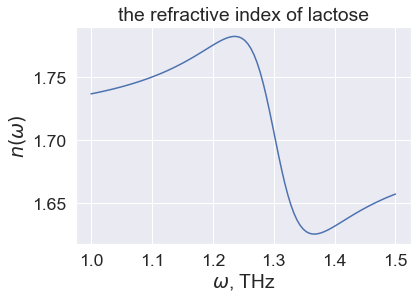

In [5]:
# Fitting to lactose data

# all units are in THz
omega = np.linspace(1, 1.5, 100)

plt.title('the refractive index of lactose')
plt.plot(
    omega,
    np.sqrt(
        SOSpectroscopy.epsilon(
            omega=omega,
            n0=1.7,
            gamma=0.13,
            omega0=1.3,
            omega_p=0.300,
        )
    ).real
)

plt.xlabel('$\omega$, THz')
plt.ylabel('$n(\omega)$')
plt.show()

In [6]:
sos = SOSpectroscopy(
    omega_measurements=np.linspace(0.4, 0.8, 5), 
    
    # parameters taken from the fit above
    n0=1.7,
    gamma=0.130,
    omega0=1.3,

    # sample 1: contains lactose
    omega_p1=0.300,
    
    # sample 2: contains NO lactose
    omega_p2=0,
)

At max_ampl = 5e+03 no constraints are activated


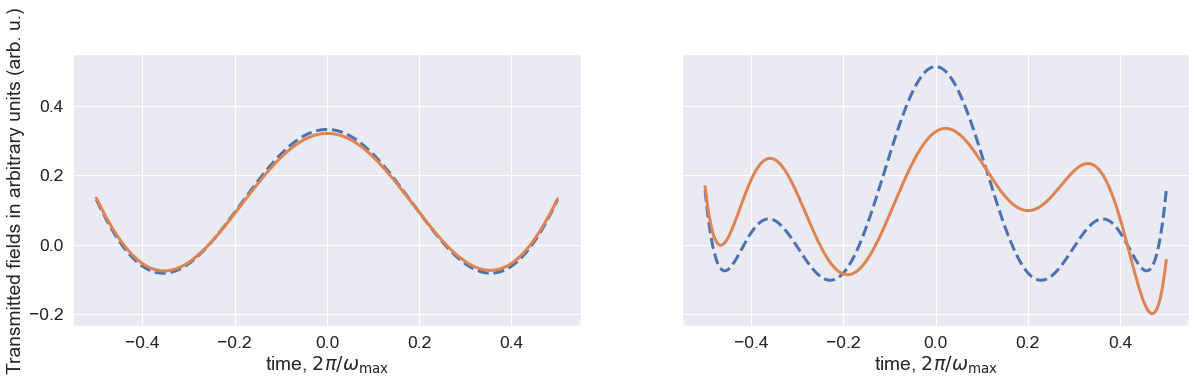

In [7]:
#sos.discrimination(max_amplitudes=[1e1, 1e2, 1e3, 0.2e4, 0.5e4])
sos.discrimination(max_amplitudes=[0.5, 0.5e4,])
#plt.legend()
plt.show()

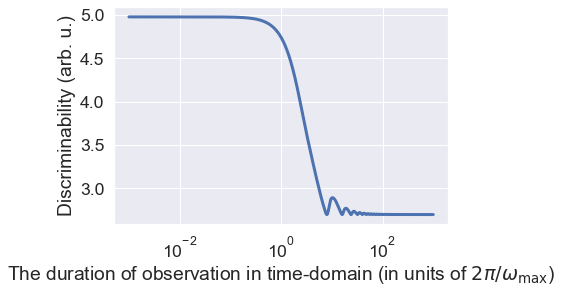

In [8]:
sos.discriminability_time_interval(sos.short_half_period * np.logspace(-3, 3, 1000))
plt.show()

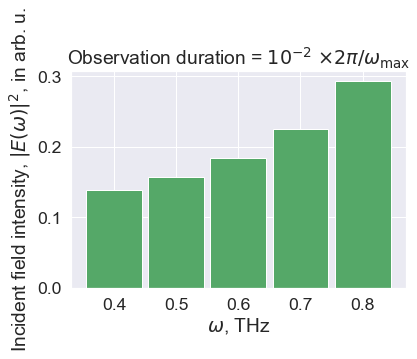

In [9]:
sos.fields_transmitted(sos.short_half_period * 1e-2)

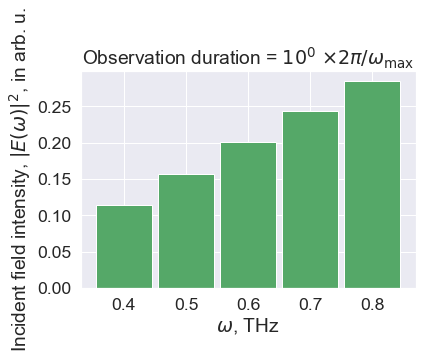

In [10]:
sos.fields_transmitted(sos.short_half_period * 1)

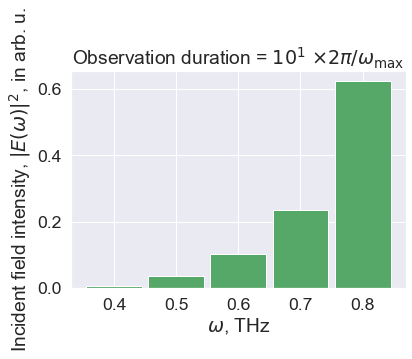

In [11]:
sos.fields_transmitted(sos.short_half_period * 10)

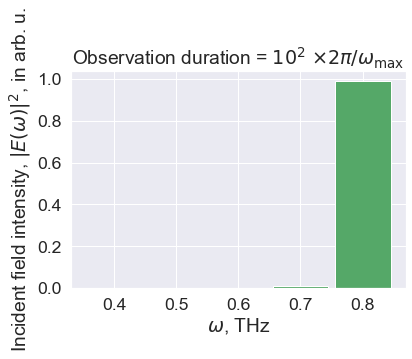

In [12]:
sos.fields_transmitted(sos.short_half_period * 1e2)

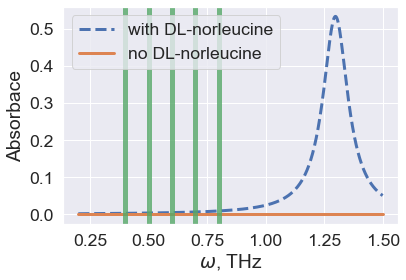

In [13]:
sos.plot_setup()

# Enhanced polarimetry with entangled superoscillations

In [14]:
class EntangledSOSpectroscopy:
    """
    Entangled superoscillating spectroscopy
    """
    def __init__(self, *, omega_measurements, epsilon_inf, gamma, omega_p, omega_c1, omega_c2):
        """
        We use the model from Lin et. al, Adv. Optical Mater. 2018, 1800572 
        """
        # save parameters
        self.epsilon_inf = epsilon_inf
        self.gamma = gamma
        self.omega_p = omega_p
        self.omega_c1 = omega_c1
        self.omega_c2 = omega_c2
        self.omega_measurements = omega_measurements[np.newaxis, :]
        
        # generating time grids
        self.short_half_period = np.pi / np.abs(omega_measurements).max()
        self.short_time = np.linspace(-self.short_half_period, self.short_half_period, 500)[:, np.newaxis]
        self.short_period = 2. * self.short_half_period
        
    def discriminability_time_interval(self, half_durations):
        """
        Quantify how the degree of discriminability of two materials depends 
        on the duration of observation in time-domain
        """
        num_time_steps = 1000
        
        discriminability = []
        von_neumann_entropy = []
        
        for half_duration in half_durations:
    
            # generating time grid
            t = np.linspace(-half_duration, half_duration, num_time_steps)

            # get the largest singular value
            A = self.omega2time(self.omega_c1, t) - self.omega2time(self.omega_c2, t)
            #print(A.shape)
            #singular_values = linalg.svdvals(
            #    A
            #).max()
            U, s, Vh = linalg.svd(A, overwrite_a=True)
            discriminability.append(s[0])
 
            # get the Schmidt decomposition
            schmidt_coeffs = linalg.svdvals(Vh[0].reshape(2, -1))
    
            # get the von Neumann entropy
            p = schmidt_coeffs ** 2
        
            von_neumann_entropy.append(-np.sum(p * np.log2(p)))
            
            #print(np.abs(Vh[0].reshape(2, -1)) ** 2)
            
            
        _, ax1 = plt.subplots()
        ax1.semilogx(half_durations / self.short_half_period, discriminability, 'r', linewidth=3)
    
        ax1.set_xlabel("The duration of observation in time-domain (in units of $2 \pi / \omega_\max$)")
        ax1.set_ylabel("Discriminability (arb. u.)", color='r')
        
        ax2 = ax1.twinx()
        ax2.semilogx(half_durations / self.short_half_period, von_neumann_entropy, 'y', linewidth=3)
        ax2.set_ylabel("von Neumann entropy", color='y')
        
    def omega2time(self, omega_c, t):
        """
        The matrix of the operator transforming the frequency domain to time domain signal including polarization
        """
        # getting correct shape for time array
        t = t[:, np.newaxis]
        
        # get the components of permutivity tensor
        epsilon_xx = epsilon_yy = self.epsilon_xx(self.omega_measurements, omega_c)
        epsilon_xy = self.epsilon_xy(self.omega_measurements, omega_c)
        epsilon_yx = epsilon_xy.conj()
        
        # oscilating fileds
        exp_omega_t = np.exp(1j * self.omega_measurements * t)
        
        return np.block([
            [epsilon_xx * exp_omega_t, epsilon_xy * exp_omega_t],
            [epsilon_yx * exp_omega_t, epsilon_yy * exp_omega_t]
        ])
    
    def epsilon_xx(self, omega, omega_c):
        return self.epsilon_inf - self.omega_p ** 2 * (omega ** 2 + 1j * self.gamma * omega) / \
                                    ((omega ** 2 + 1j * self.gamma * omega) ** 2 - omega ** 2 * omega_c ** 2)
    
    def epsilon_xy(self, omega, omega_c):
        return 1j * self.omega_p ** 2 * omega * omega_c / \
                                    ((omega ** 2 + 1j * self.gamma * omega) ** 2 - omega ** 2 * omega_c ** 2)

In [15]:
# All units are in THz
esos = EntangledSOSpectroscopy(
    omega_measurements=np.linspace(400, 800, 5),
    
    # Values used from Lin et. al, Adv. Optical Mater. 2018, 1800572 
    epsilon_inf=15.6,
    gamma=1e3,
    omega_p=1.2408e4,
    
    # cyclotron frequencies that are proportional to the magnetic field
    omega_c1=6.2832e3,
    omega_c2=1.02 * 6.2832e3,
)

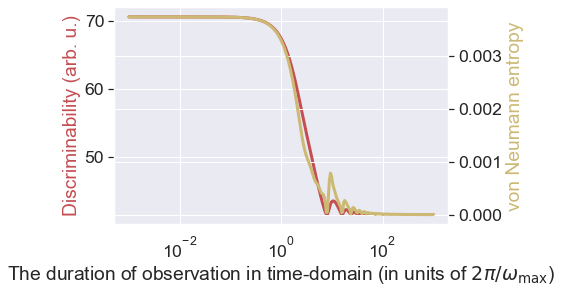

In [16]:
esos.discriminability_time_interval(esos.short_half_period * np.logspace(-3, 3, 300))
plt.show()